**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Encodings para texto y LDA

En esta notebook, utilizaremos el conjunto de datos **obtenido** en la notebook `07_CombinacionCoordenadas.ipynb`, que contiene los datos de ventas de propiedades en Melbourne de esta [competencia de Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot), al cual se le agregó una columna con las descripciones del vecindario, extraídas de un [conjunto de datos de scrapings](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) de publicaciones de AirBnB.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

seaborn.set_context('talk')

In [2]:
# This allows us to print more information per column
pandas.set_option('display.max_colwidth', 500)

In [3]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_extended_neighborhood_overview.csv')

melb_df.sample(3, random_state=123)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,closest_airbnb_neighborhood_overview
5799,St Kilda,25/69 Wellington St,2,u,542500.0,PI,McGrath,10/09/2016,6.1,3182.0,...,1.0,0.0,NaN,NaN,Port Phillip,-37.8568,144.98730,Southern Metropolitan,13240.0,"\nSt Kilda is a vibrant inner suburb, right on the beach and minutes from the CBD.\nWith Albert Park at the bottom of the street, and the trendy Chapel Street bars and restaurants at the other end, this apartment is perfectly situated to explore Melbourne, and is walking distance to Bayside attractions, and the Grand Prix.\nThere are plenty of hip cafes down Carlisle St , Las Chicas being one of my favourite breakfast haunts ! Glenferrie Rd shopping centre is a suburb away in Malvern . A cou..."
10596,Broadmeadows,48 Walsh St,3,h,386000.0,S,hockingstuart,8/07/2017,14.0,3047.0,...,1.0,341.0,71.0,1965.0,Hume,-37.6886,144.92281,Northern Metropolitan,4294.0,"\nFairly quiet family suburb, close to Glenroy shops.\n\nVery quiet and peaceful. No noise from train, traffic or freeway\n\n\n\n\nThe neighbourhood is very quiet and private.\nEase of access to freeways from North South and west. 15 minutes to city by car on city link, 24hr Kmart down the road and eateries, shopping centre within 1km"
7471,Ascot Vale,17 Monash St,3,h,1230000.0,PI,Nelson,20/05/2017,5.9,3032.0,...,2.0,538.0,NaN,NaN,Moonee Valley,-37.7808,144.90830,Western Metropolitan,6567.0,"# Flemington Racecourse 1.6 km # Melbourne Showgrounds 600m # Maribyrnong River Trail 950m # Ascot Vale Leisure Centre (indoor swimming pool, gym) 700m # Ascot Chase Wetlands & Playground 300m # Riverside Golf & Tennis Centre 650m # Highpoint Shopping Centre 1.7 km # Moonee Ponds Shopping District 1.8 km\nThe neighbourhood is very friendly and quiet with great parks, cafes/ restaurants and public transport nearby. Locations walking distance nearby include: - Golf course/driving range - Tenni..."


## Explorando texto libre

Los datos no estructurados, como el texto libre o las imágenes, tienen métodos específicos para poder analizarlos. En este notebook trataremos de entender qué tipo de información nos aportan las descripciones de los vecindarios, y si puede ser de utilidad en nuestra tarea de predicción de precios.

Es útil saber qué cantidad de texto tenemos por instancia, para comenzar a estimar la cantidad de información representada y algunas características de los documentos.
Por ejemplo, no es lo mismo analizar *tweets* en **Twitter** que analizar *documentos* en **Wikipedia**.

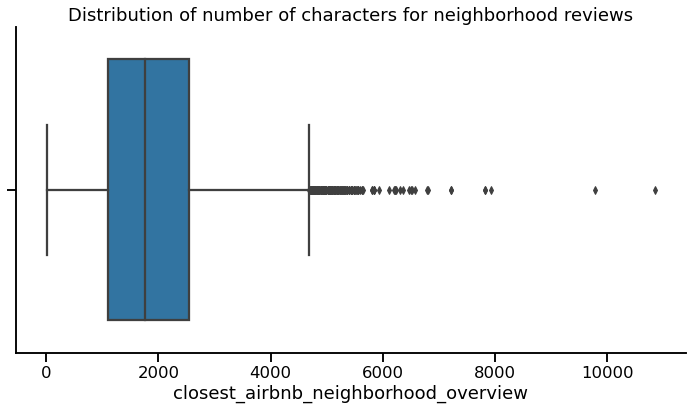

In [4]:
plt.figure(figsize=(12, 6))
plt.title('Distribution of number of characters for neighborhood reviews')

seaborn.boxplot(x=melb_df.closest_airbnb_neighborhood_overview.apply(len))

seaborn.despine()

## Análisis de frecuencias de palabras

### Nubes de palabras por `CouncilArea`

Una buena representación visual para entender de qué *habla* un texto son las nubes de palabras. 

In [5]:
def sample_text_from_col(df, n=100, text_col='closest_airbnb_neighborhood_overview'):
    """
    Extract a sample of text from column @text_col.
    """
    n = min(n, len(df))
    return '\n'.join(df.sample(n, random_state=123)[text_col].values)

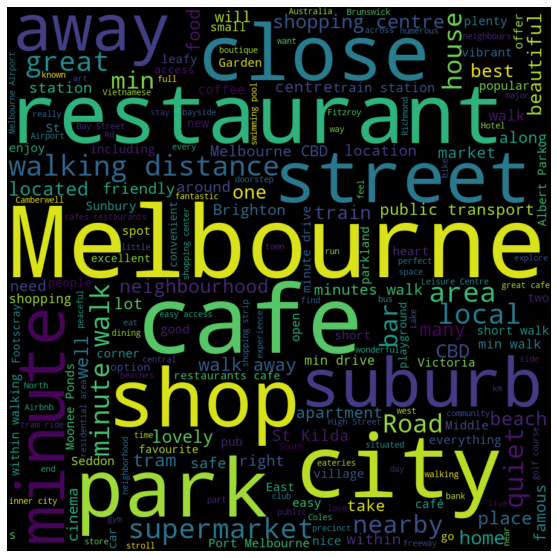

In [6]:
from wordcloud import WordCloud

text_sample = sample_text_from_col(melb_df)

wc = WordCloud(width=900, height=900, max_font_size=200).generate(text_sample)

plt.figure(figsize=(12, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Podemos ahora crear nubes de palabras para las descripciones de `CouncilArea`.

In [7]:
unique_council_areas = melb_df.CouncilArea.unique()

text_samples_for_areas = {
    area: sample_text_from_col(melb_df[melb_df.CouncilArea == area])
    for area in unique_council_areas if isinstance(area, str)
}

list(text_samples_for_areas.keys())

['Yarra',
 'Moonee Valley',
 'Port Phillip',
 'Darebin',
 'Hobsons Bay',
 'Stonnington',
 'Boroondara',
 'Monash',
 'Glen Eira',
 'Whitehorse',
 'Maribyrnong',
 'Bayside',
 'Moreland',
 'Manningham',
 'Banyule',
 'Melbourne',
 'Kingston',
 'Brimbank',
 'Hume',
 'Knox',
 'Maroondah',
 'Casey',
 'Melton',
 'Greater Dandenong',
 'Nillumbik',
 'Whittlesea',
 'Frankston',
 'Macedon Ranges',
 'Yarra Ranges',
 'Wyndham',
 'Cardinia',
 'Unavailable',
 'Moorabool']

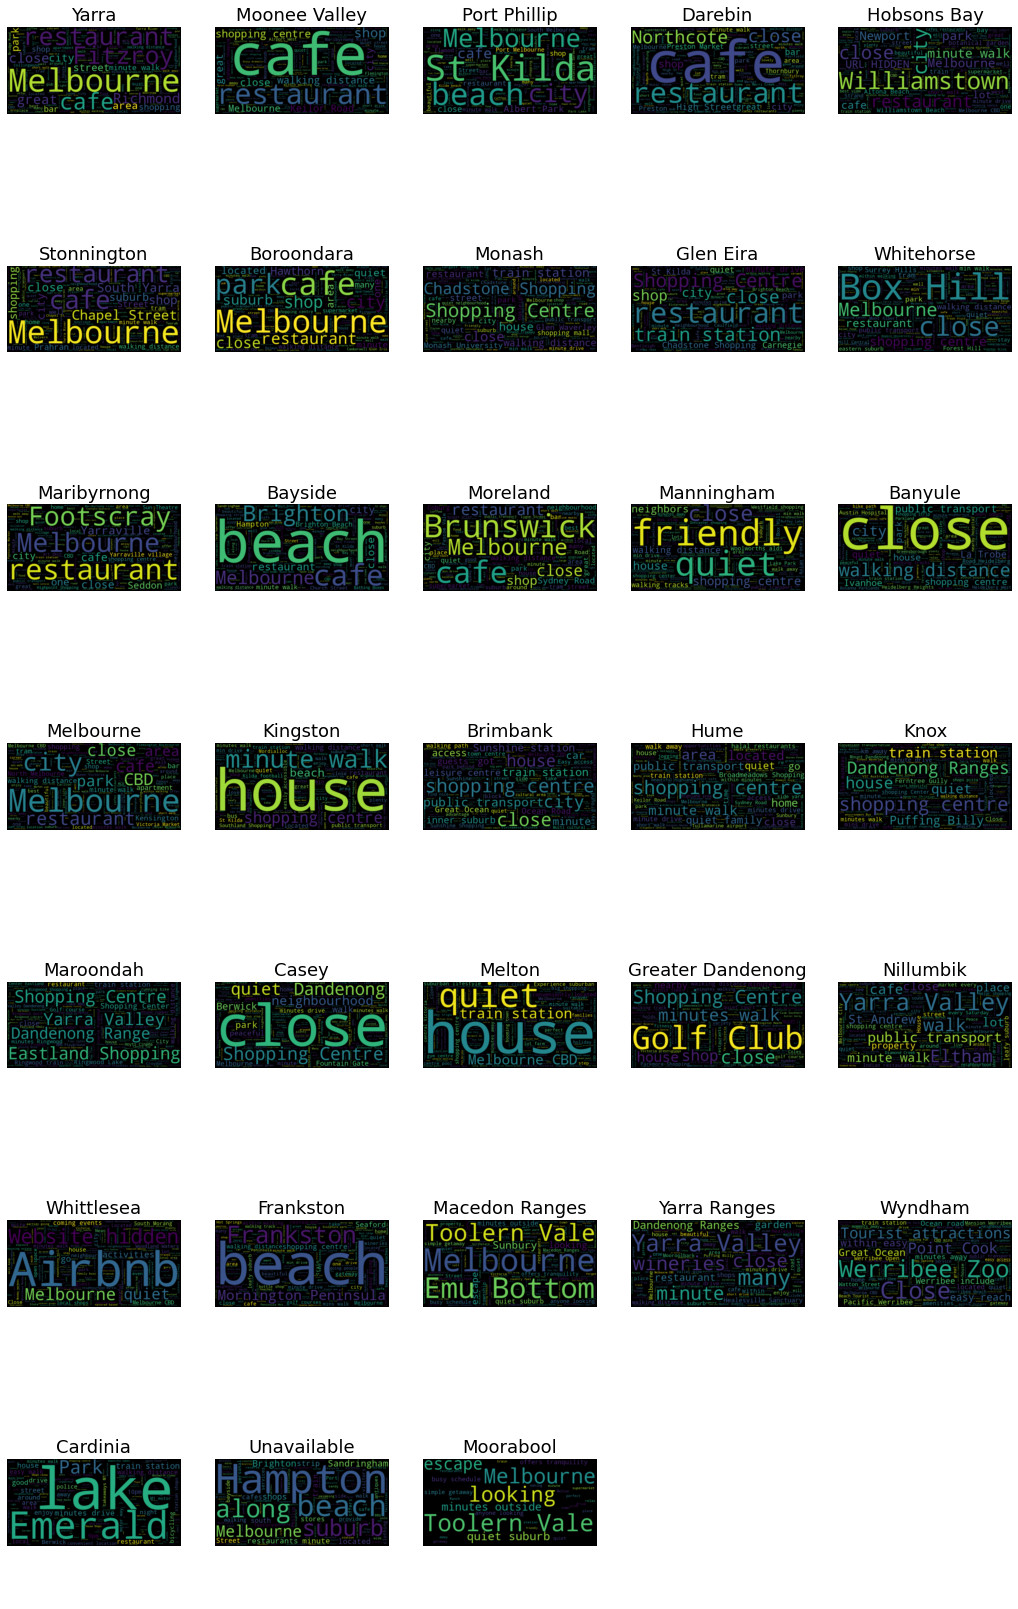

In [8]:
import math

# Create general layout
n_cols = 5
n_rows = math.ceil(len(text_samples_for_areas) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 30))

for i, (area, text_sample) in enumerate(text_samples_for_areas.items()):
    wc = WordCloud(width=600, height=300, max_font_size=200).generate(text_sample)
    # Calculamos filas y columnas
    row = math.floor(i / n_cols)
    col = i % n_cols
    # Configuramos visualización
    ax = axs[row, col]
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(area)

# Limpiamos subplots vacíos
for col in range(n_cols):
    for row in range(n_rows):
        if not axs[row, col].lines:
            axs[row, col].axis('off')

## Codificación de variables con texto libre

Si bien las nubes de palabras son muy intuitivas, no podemos usarlas para realizar análisis numérico.
De la misma forma que los datos categóricos, los datos textuales necesitan ser codificados en vectores.

En esta mini-introducción utilizaremos un encoding de *bolsa de palabras*, o *bag-of-words* en inglés.

Se define...

1. $W$ el conjunto de palabras llamado *vocabulario*, y sea $M = |W|$ su tamaño. Es decir, existen $M$ palabras distintas en nuestro documento.
2. $w_i \in W$ la palabra número $i$ del vocabulario.

Utilizando la clase `CountVectorizer` de *scikit-learn*, se proyecta el documento a un vector $v \in \mathbb{R}^{M}$ donde cada columna $i$ se rellena con el número de veces en las que cada palabra $w_i$ ocurre en el documento.

Para evitar una explosión de dimensiones, limitaremos el tamaño del vocabulario sólo a las palabras más frecuentes.
Las palabras más frecuentes de un idioma, como *él*, *de*, son muy poco informativas.
Se las denomina *stopwords*.
Por ello, generalmente se ignoran en este tipo de representaciones.

**Nota**
Esta representación es una de las más simples de obtener, sin embargo, existen otras proyecciones más adecuadas.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
vocab_size = 500 # Only 500 most frequent words

vectorizer = CountVectorizer(max_features=vocab_size, stop_words='english')

tokens = vectorizer.fit_transform(melb_df.closest_airbnb_neighborhood_overview)

In [11]:
vectorizer.get_feature_names()[:10]

['10', '11', '12', '15', '1km', '20', '25', '30', '5km', 'access']

In [12]:
tokens.shape

(13580, 500)

Podemos ver la frecuencia de cada palabra...

In [13]:
word_frequencies = pandas.DataFrame(
    data={
        'frequency': tokens.sum(axis=0).flatten().tolist()[0],
        'tokens': vectorizer.get_feature_names()
    }
)

word_frequencies.sort_values('frequency', ascending=False)

,frequency,tokens
271,43319,melbourne
479,39023,walk
373,31122,restaurants
394,30963,shopping
65,29747,cafes
...,...,...
466,919,use
132,917,doncaster
94,917,clothing
492,916,woolworth


## Reducción de dimensionalidad

Los vectores que representan cada uno de nuestros comentarios no nos sirven para poder entender los datos, porque no podemos pensar en cientos de dimensiones al mismo tiempo.
Son demasiado *anti-intuitivos*.

Podemos intentar aplicar un método como **PCA** para reducir la dimensionalidad de los vectores, pero esto no nos devolverá vectores que nosotros podamos leer o entender.

Por suerte, existen formas de transformarlos en representaciones que sean más *human-friendly*.

[LDA](https://scikit-learn.org/stable/modules/decomposition.html?highlight=lda#latent-dirichlet-allocation-lda) o *Latent Dirichlet Allocation* es un modelo que asume que cada texto habla de un tema o *topic* desconocido.

Cuando es entrenado, encuentra grupos de palabras (vectores) que corresponden a los *topics* que mejor explicarían los datos.

In [14]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=0)

lda.fit(tokens)

LatentDirichletAllocation(n_components=5, random_state=0)

In [15]:
lda.components_

array([[3015.06143567,   62.82532619,  456.57621896, ...,  192.63185845,
         231.88848442,    8.42601304],
       [2079.81220916,  218.50931868,  178.22770008, ...,  289.85760683,
         672.92091467,  812.5746923 ],
       [4312.44048363,  464.68065737,  346.14242396, ...,  197.39573469,
          95.89438469,  212.21665021],
       [1800.30404957,  212.86351659,  207.63139762, ...,  144.64161377,
         218.90033053,   14.7983414 ],
       [1968.38182197,  179.12118117,   70.42225938, ...,  279.47318626,
         199.3958857 ,  482.98430305]])

In [16]:
lda.components_.shape

(5, 500)

In [17]:
feature_names = vectorizer.get_feature_names()

In [18]:
def plot_top_words(model, feature_names, n_top_words=10, title=''):
    n_cols = 2
    n_rows = math.ceil(model.n_components / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 15), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = (-topic).argsort()[:n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    # Limpiamos subplots vacíos
    for ax in axes:
        if not ax.has_data():
            ax.remove()

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

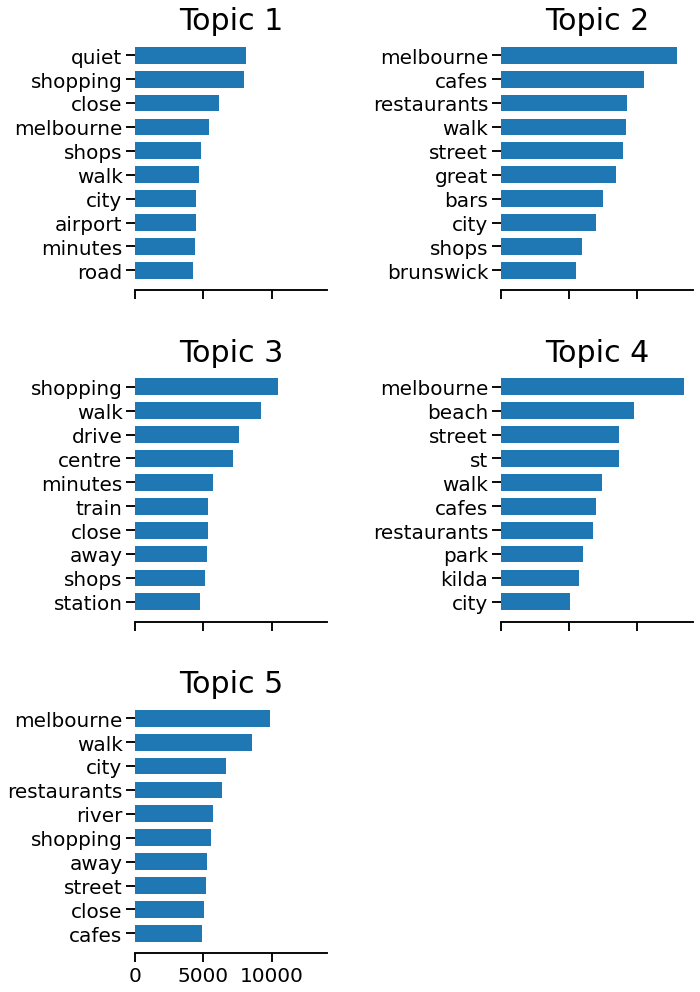

In [19]:
plot_top_words(lda, feature_names)

Ahora podemos utilizar el modelo para determinar cuál es la probabilidad que un texto sea generado por ese tópico.
Es decir... *Que tanto del tema **X** habla el documento*.

In [20]:
lda_columns = ['topic{}'.format(i + 1) for i in range(lda.n_components)]

melb_df[lda_columns] = lda.transform(tokens)

In [21]:
melb_df[['closest_airbnb_neighborhood_overview'] + lda_columns].sample(random_state=123)

,closest_airbnb_neighborhood_overview,topic1,topic2,topic3,topic4,topic5
5799,"\nSt Kilda is a vibrant inner suburb, right on the beach and minutes from the CBD.\nWith Albert Park at the bottom of the street, and the trendy Chapel Street bars and restaurants at the other end, this apartment is perfectly situated to explore Melbourne, and is walking distance to Bayside attractions, and the Grand Prix.\nThere are plenty of hip cafes down Carlisle St , Las Chicas being one of my favourite breakfast haunts ! Glenferrie Rd shopping centre is a suburb away in Malvern . A cou...",0.037462,0.001246,0.001249,0.958805,0.001239


Ahora podemos ver las correlaciones entre los tópicos y el resto de las variables en nuestro conjunto de datos.
Es posible ver que existe una cierta correlación entre el primer tópico con algunos de los valores posibles para `CouncilArea`.

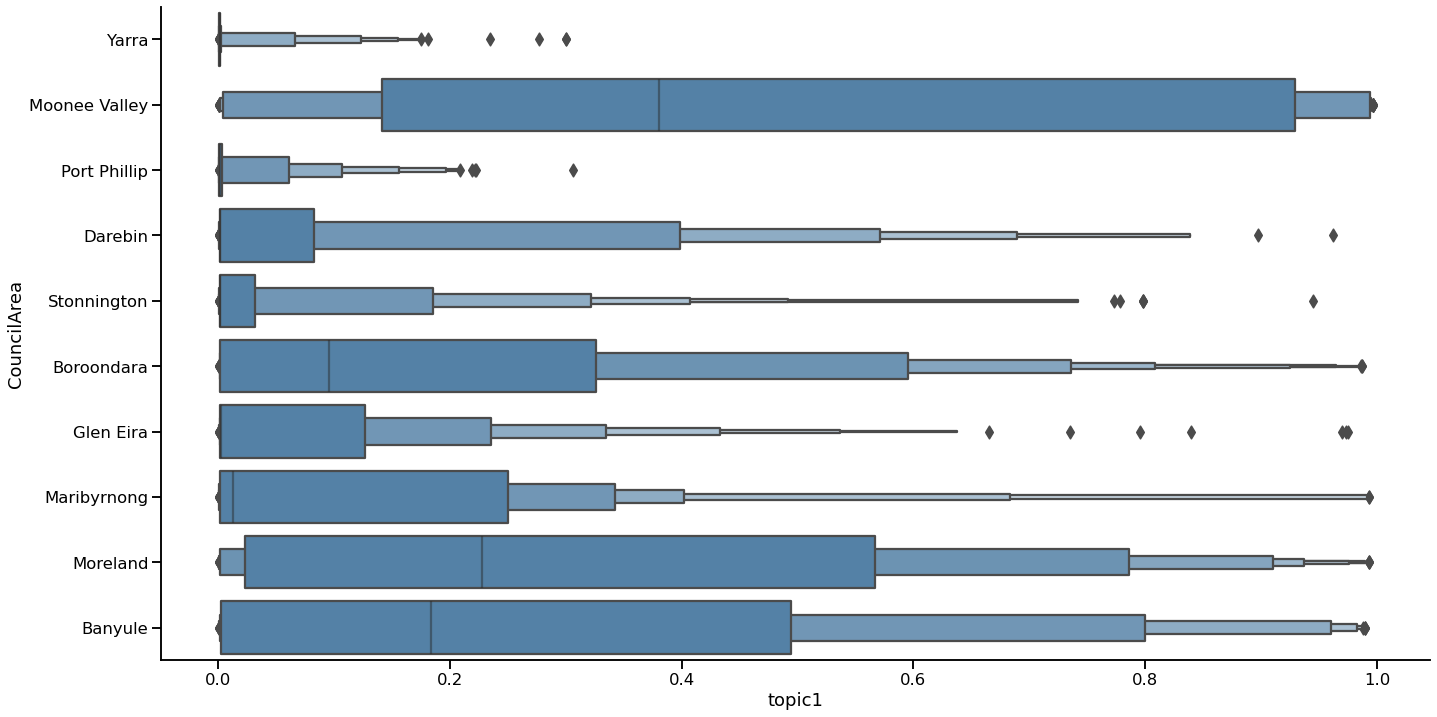

In [22]:
most_common_areas = melb_df.CouncilArea.value_counts().head(10).index

seaborn.catplot(data=melb_df[melb_df.CouncilArea.isin(most_common_areas)],
                x='topic1',
                y='CouncilArea',
                kind='boxen',
                height=10,
                aspect=2,
                color='steelblue');

¿Nos sirve para poder estimar mejor el precio de una propiedad?
Si graficamos la distribución de precios para cada tópico (tomando sólo el tópico más probable para cada documento), no observamos mucha variabilidad.

In [23]:
melb_df['most_likely_topic'] = melb_df[lda_columns].values.argmax(axis=1) + 1

melb_df[lda_columns + ['most_likely_topic']].head()

,topic1,topic2,topic3,topic4,topic5,most_likely_topic
0,0.000458,0.239827,0.048415,0.000457,0.710844,5
1,0.000307,0.477759,0.000308,0.044790,0.476835,2
2,0.000295,0.594901,0.000295,0.082541,0.321968,2
3,0.025602,0.191831,0.105826,0.000408,0.676333,5
4,0.000379,0.515925,0.000381,0.000382,0.482933,2


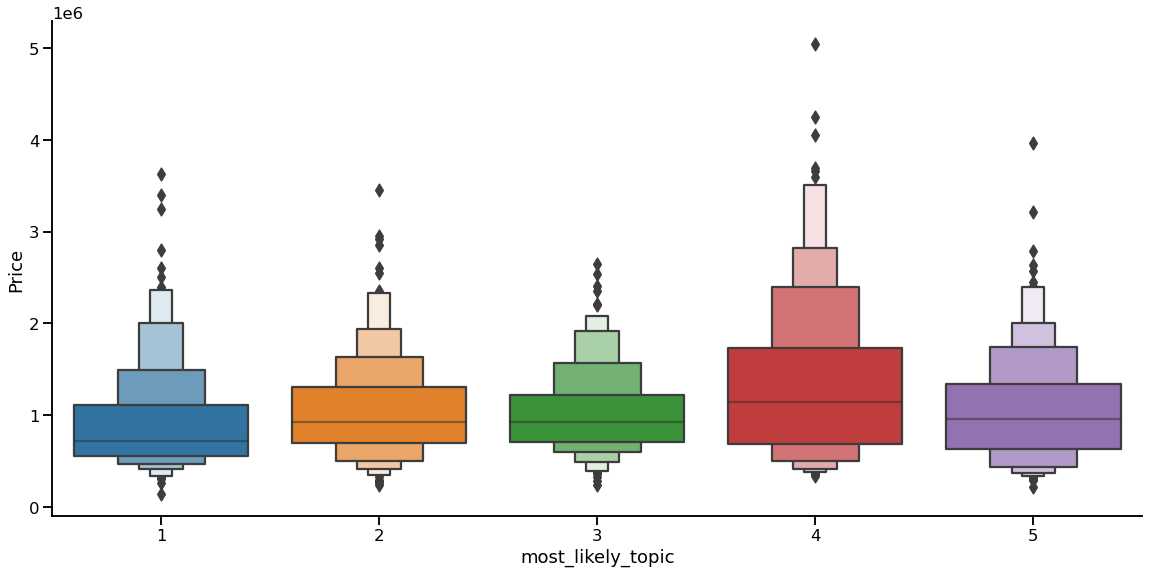

In [24]:
seaborn.catplot(data=melb_df.sample(1000, random_state=123),
                x='most_likely_topic',
                y='Price',
                kind='boxen',
                height=8,
                aspect=2);

**Ejercicio:** Proyectar la columna con descripciones textuales con PCA, y graficar las dos primeras componentes.

In [25]:
tokens.shape

(13580, 500)

In [26]:
type(tokens)

scipy.sparse.csr.csr_matrix

In [27]:
precision_type = numpy.float32

dense_tokens = tokens.astype(precision_type).todense()

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaled_dense_tokens = StandardScaler().fit_transform(dense_tokens)

# ¿Se deberían escalar las columnas de tokens, o no?
pca = PCA(n_components=15)
pca.fit(scaled_dense_tokens)

proyected_tokens = pca.transform(scaled_dense_tokens)
proyected_tokens.shape

(13580, 15)

In [29]:
pca.explained_variance_ratio_

array([0.04578349, 0.02096728, 0.01706974, 0.01535818, 0.01409302,
       0.01361771, 0.01322327, 0.01189089, 0.01122471, 0.01098695,
       0.01033609, 0.00970199, 0.00922   , 0.00906712, 0.00873052],
      dtype=float32)

In [30]:
melb_df['pca1'] = proyected_tokens[:, 0]
melb_df['pca2'] = proyected_tokens[:, 1]

In [31]:
melb_df.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Propertycount,closest_airbnb_neighborhood_overview,topic1,topic2,topic3,topic4,topic5,most_likely_topic,pca1,pca2
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,4019.0,"Neighbourhood is quiet but super close to the city and has everything that the inner east/ north has to offer.\nAbbotsford is one of the highly sought after inner city locations. It is eclectic in its mix of residential, businesses, shops, pubs, bars and cafes. Commuting to the city is easy by car, train, tram, bus, bike or walking. In 15 minutes you can be at Rod Laver Arena or the MCG. Or walk there in 25. Across the street is Victoria Park, an open public space where you can barbecue, sit...",0.000458,0.239827,0.048415,0.000457,0.710844,5,20.738129,1.983159
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,4019.0,"Abbotsford is a small, leafy, inner city suburb in Melbourne – surrounded by Richmond, Collingwood, and the Yarra River. You will find some of the best Asian restaurants in town are just 2 mins walk away in the famous Victoria Street. Some of Abbotsford highlights include Yarra Bend Park, the Collingwood Children’s Farm and the historical Abbotsford Convent. You can even follow the Capital City Trail all the way to the CBD following the Yarra river all the way. Lastly you may like to enjoy...",0.000307,0.477759,0.000308,0.044790,0.476835,2,39.096416,-1.560136
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,4019.0,"One thing I often get is people don't realize how good this location is until they arrive. 10 minutes walk to the famous Abbotsford convent, close to Fitzroy and Melbourne botanical garden and Melbourne Cricket ground. On one side you have all the prominent cafes, exquisite restaurants, bbqs, dessert house, bars, shopping strips, entertainment, music/DVDs, cinemas, local bakery.. a multicultural bonanza. On the other side you have gardens, parks, river, walking trails, castles and convents,...",0.000295,0.594901,0.000295,0.082541,0.321968,2,42.278008,-3.385220


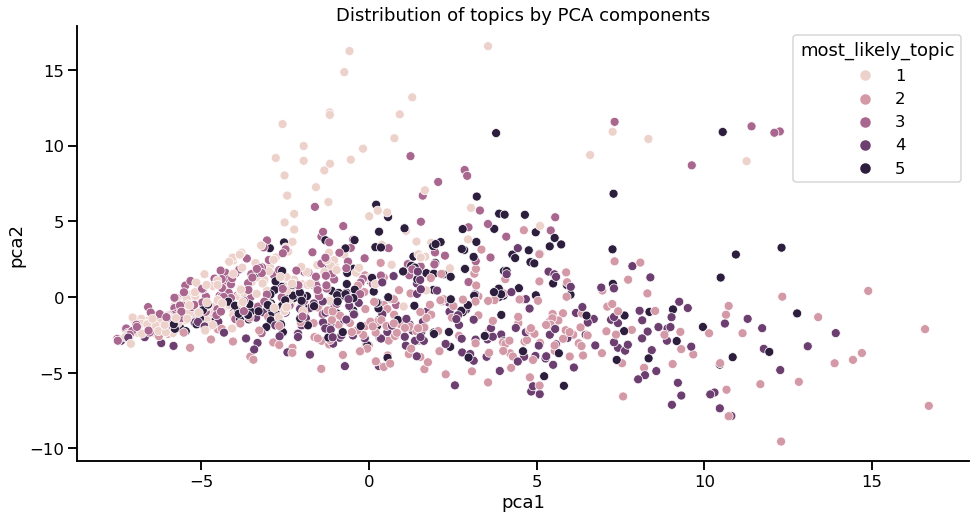

In [32]:
cols = ['most_likely_topic', 'pca1', 'pca2']

data = melb_df[cols].sample(1000, random_state=123)

plt.figure(figsize=(16, 8))
plt.title('Distribution of topics by PCA components')

seaborn.scatterplot(data=data, x='pca1', y='pca2', hue='most_likely_topic')
seaborn.despine()

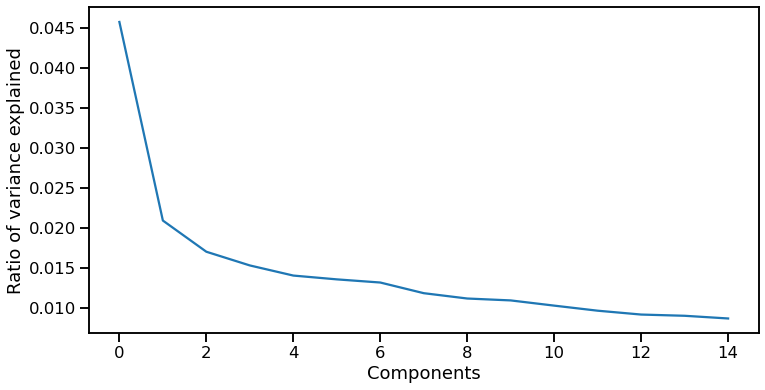

In [33]:
fig = plt.figure(figsize=(12, 6))

seaborn.lineplot(x=range(pca.n_components), y=pca.explained_variance_ratio_)

plt.xlabel("Components");
plt.ylabel("Ratio of variance explained");